In [1]:
import os, pickle, glob
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.types import Row, StructField, StructType, StringType, IntegerType, BinaryType
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import pyspark.pandas as ps
import plotly

Matplotlib created a temporary cache directory at /scratch/cscholz/job_30364003/matplotlib-se5umked because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
/usr/local/spark/python/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


In [2]:
sc = SparkSession.builder \
    .config("spark.driver.memory", "64g") \
    .config("spark.executor.memory", "16g") \
    .config("spark.executor.instances", 4) \
    .getOrCreate()

# Import Data

In [3]:
path = 'merged_data.csv'

In [4]:
df = sc.read.csv(path, header=True, inferSchema=True, escape="\"")

# Initial Exploration

In [5]:
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- rank: integer (nullable = true)
 |-- date: date (nullable = true)
 |-- artist: string (nullable = true)
 |-- url: string (nullable = true)
 |-- region: string (nullable = true)
 |-- chart: string (nullable = true)
 |-- trend: string (nullable = true)
 |-- streams: double (nullable = true)
 |-- track_id: string (nullable = true)
 |-- album: string (nullable = true)
 |-- popularity: double (nullable = true)
 |-- duration_ms: double (nullable = true)
 |-- explicit: boolean (nullable = true)
 |-- release_date: string (nullable = true)
 |-- available_markets: string (nullable = true)
 |-- af_danceability: double (nullable = true)
 |-- af_energy: double (nullable = true)
 |-- af_key: double (nullable = true)
 |-- af_loudness: double (nullable = true)
 |-- af_mode: double (nullable = true)
 |-- af_speechiness: double (nullable = true)
 |-- af_acousticness: double (nullable = true)
 |-- af_instrumentalness: doub

In [8]:
df.columns

['_c0',
 'title',
 'rank',
 'date',
 'artist',
 'url',
 'region',
 'chart',
 'trend',
 'streams',
 'track_id',
 'album',
 'popularity',
 'duration_ms',
 'explicit',
 'release_date',
 'available_markets',
 'af_danceability',
 'af_energy',
 'af_key',
 'af_loudness',
 'af_mode',
 'af_speechiness',
 'af_acousticness',
 'af_instrumentalness',
 'af_liveness',
 'af_valence',
 'af_tempo',
 'af_time_signature']

In [6]:
#count number of records and columns in the dataset
print('number of records: ' + str(df.count()))
print('number of columns: ' + str(len(df.columns)))

number of records: 26174269
number of columns: 29


In [5]:
#drop null records from dataset
df2 = df.dropna("any")
df2.show()

+---+--------------------+----+----------+--------------------+--------------------+---------+------+-------------+--------+--------------------+--------------------+----------+-----------+--------+------------+--------------------+---------------+---------+------+-----------+-------+--------------+---------------+-------------------+-----------+----------+--------+-----------------+
|_c0|               title|rank|      date|              artist|                 url|   region| chart|        trend| streams|            track_id|               album|popularity|duration_ms|explicit|release_date|   available_markets|af_danceability|af_energy|af_key|af_loudness|af_mode|af_speechiness|af_acousticness|af_instrumentalness|af_liveness|af_valence|af_tempo|af_time_signature|
+---+--------------------+----+----------+--------------------+--------------------+---------+------+-------------+--------+--------------------+--------------------+----------+-----------+--------+------------+---------------

In [9]:
#count number of records after nulls are dropped
print('number of records: ' + str(df2.count()))

number of records: 20302985


In [10]:
#check for duplicates
duplicates = df2.groupBy(df2.columns)\
    .agg(F.count("*").alias("count"))\
    .filter(F.col("count") > 1)

duplicates.show()

+---+-----+----+----+------+---+------+-----+-----+-------+--------+-----+----------+-----------+--------+------------+-----------------+---------------+---------+------+-----------+-------+--------------+---------------+-------------------+-----------+----------+--------+-----------------+-----+
|_c0|title|rank|date|artist|url|region|chart|trend|streams|track_id|album|popularity|duration_ms|explicit|release_date|available_markets|af_danceability|af_energy|af_key|af_loudness|af_mode|af_speechiness|af_acousticness|af_instrumentalness|af_liveness|af_valence|af_tempo|af_time_signature|count|
+---+-----+----+----+------+---+------+-----+-----+-------+--------+-----+----------+-----------+--------+------------+-----------------+---------------+---------+------+-----------+-------+--------------+---------------+-------------------+-----------+----------+--------+-----------------+-----+
+---+-----+----+----+------+---+------+-----+-----+-------+--------+-----+----------+-----------+--------+

In [11]:
#check data types of revised df
df2.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- rank: integer (nullable = true)
 |-- date: date (nullable = true)
 |-- artist: string (nullable = true)
 |-- url: string (nullable = true)
 |-- region: string (nullable = true)
 |-- chart: string (nullable = true)
 |-- trend: string (nullable = true)
 |-- streams: double (nullable = true)
 |-- track_id: string (nullable = true)
 |-- album: string (nullable = true)
 |-- popularity: double (nullable = true)
 |-- duration_ms: double (nullable = true)
 |-- explicit: boolean (nullable = true)
 |-- release_date: string (nullable = true)
 |-- available_markets: string (nullable = true)
 |-- af_danceability: double (nullable = true)
 |-- af_energy: double (nullable = true)
 |-- af_key: double (nullable = true)
 |-- af_loudness: double (nullable = true)
 |-- af_mode: double (nullable = true)
 |-- af_speechiness: double (nullable = true)
 |-- af_acousticness: double (nullable = true)
 |-- af_instrumentalness: doub

In [6]:
#convert strings to integers where needed
df2 = df2.withColumn("streams", df2["streams"].cast("Integer"))
df2 = df2.withColumn("popularity", df2["popularity"].cast("Integer"))
df2 = df2.withColumn("duration_ms", df2["duration_ms"].cast("Integer"))

In [13]:
#recheck data types of revised df
df2.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- rank: integer (nullable = true)
 |-- date: date (nullable = true)
 |-- artist: string (nullable = true)
 |-- url: string (nullable = true)
 |-- region: string (nullable = true)
 |-- chart: string (nullable = true)
 |-- trend: string (nullable = true)
 |-- streams: integer (nullable = true)
 |-- track_id: string (nullable = true)
 |-- album: string (nullable = true)
 |-- popularity: integer (nullable = true)
 |-- duration_ms: integer (nullable = true)
 |-- explicit: boolean (nullable = true)
 |-- release_date: string (nullable = true)
 |-- available_markets: string (nullable = true)
 |-- af_danceability: double (nullable = true)
 |-- af_energy: double (nullable = true)
 |-- af_key: double (nullable = true)
 |-- af_loudness: double (nullable = true)
 |-- af_mode: double (nullable = true)
 |-- af_speechiness: double (nullable = true)
 |-- af_acousticness: double (nullable = true)
 |-- af_instrumentalness: d

# Descriptive Statistics for Select Fields

In [14]:
#streams, popularity, duration
df2.select("streams", "popularity", "duration_ms").describe().show()

+-------+------------------+------------------+------------------+
|summary|           streams|        popularity|       duration_ms|
+-------+------------------+------------------+------------------+
|  count|          20302985|          20302985|          20302985|
|   mean| 55271.43975799617| 49.01087578993926|210171.90830540436|
| stddev|209668.97662269627|30.451214851538786| 45995.50468765216|
|    min|              1001|                 0|                 0|
|    max|          19749704|                96|           9318296|
+-------+------------------+------------------+------------------+



In [15]:
#numerical af values set 1
df2.select("af_danceability", "af_energy", "af_key", "af_loudness", "af_mode", "af_speechiness").describe().show()

+-------+-------------------+-------------------+-----------------+------------------+------------------+-------------------+
|summary|    af_danceability|          af_energy|           af_key|       af_loudness|           af_mode|     af_speechiness|
+-------+-------------------+-------------------+-----------------+------------------+------------------+-------------------+
|  count|           20302985|           20302985|         20302985|          20302985|          20302985|           20302985|
|   mean| 0.6866474105310121| 0.6451090361438403|5.335599716002351|-6.128795240699589|0.5746761867774616|0.10820268905286996|
| stddev|0.13376797620633846|0.16292426985450953| 3.63979592547731|2.3848890367402027|0.4943920298378325| 0.0975365826314738|
|    min|                0.0|                0.0|              0.0|             -60.0|               0.0|                0.0|
|    max|              0.988|                1.0|             11.0|             2.216|               1.0|             

In [16]:
#number af values set 2
df2.select("af_acousticness", "af_instrumentalness", "af_liveness", "af_valence", "af_tempo", "af_time_signature").describe().show()

+-------+-------------------+--------------------+-------------------+------------------+------------------+-------------------+
|summary|    af_acousticness| af_instrumentalness|        af_liveness|        af_valence|          af_tempo|  af_time_signature|
+-------+-------------------+--------------------+-------------------+------------------+------------------+-------------------+
|  count|           20302985|            20302985|           20302985|          20302985|          20302985|           20302985|
|   mean| 0.2561906183443458| 0.00813501493904418|0.16781152442854555| 0.525369189282275| 121.0747297951098| 3.9704190295170885|
| stddev|0.24305700270926303|0.059829645564625604|0.12737166427864896|0.2215482247463698|29.510442445218686|0.25955334651543194|
|    min|                0.0|                 0.0|                0.0|               0.0|               0.0|                0.0|
|    max|              0.996|               0.993|              0.993|             0.999|        

In [17]:
#show record count for top 20 regions in descending order
df2.groupBy("region").count().sort(F.col("count").desc()).show()

+--------------+------+
|        region| count|
+--------------+------+
|        Brazil|364503|
|     Argentina|364367|
| United States|364081|
|       Austria|363878|
|     Australia|362152|
|        Global|362125|
|        Canada|361287|
|United Kingdom|359715|
|   Switzerland|358661|
|     Indonesia|358376|
|     Hong Kong|358373|
|    Costa Rica|358367|
|   New Zealand|358366|
|      Colombia|358366|
|     Singapore|358364|
|       Ecuador|358352|
|       Denmark|358348|
|   Philippines|358347|
|       Belgium|358345|
|       Ireland|358344|
+--------------+------+
only showing top 20 rows



In [19]:
#show for top 10 regions only
df2.groupBy("region").count().sort(F.col("count").desc()).show(10)

+--------------+------+
|        region| count|
+--------------+------+
|        Brazil|364503|
|     Argentina|364367|
| United States|364081|
|       Austria|363878|
|     Australia|362152|
|        Global|362125|
|        Canada|361287|
|United Kingdom|359715|
|   Switzerland|358661|
|     Indonesia|358376|
+--------------+------+
only showing top 10 rows



In [20]:
#group by artists that occur most frequently
df2.groupBy("artist").count().sort(F.col("count").desc()).show()

+---------------+------+
|         artist| count|
+---------------+------+
|     Ed Sheeran|366022|
|  Billie Eilish|230007|
|    Post Malone|196620|
|      Bad Bunny|187425|
|  Ariana Grande|174396|
|       Dua Lipa|173678|
|          Drake|156844|
|Imagine Dragons|144067|
|   XXXTENTACION|142029|
|     The Weeknd|133966|
|            BTS|132299|
|  Justin Bieber|120873|
|   Travis Scott|111777|
|     Juice WRLD|111656|
|   Shawn Mendes|102381|
|   Harry Styles| 97672|
|         Maluma| 95663|
|       Maroon 5| 95206|
|  Lewis Capaldi| 93542|
|      Sam Smith| 88078|
+---------------+------+
only showing top 20 rows



In [21]:
#group by top 10 artists that occur most frequently
df2.groupBy("artist").count().sort(F.col("count").desc()).show(10)

+---------------+------+
|         artist| count|
+---------------+------+
|     Ed Sheeran|366022|
|  Billie Eilish|230007|
|    Post Malone|196620|
|      Bad Bunny|187425|
|  Ariana Grande|174396|
|       Dua Lipa|173678|
|          Drake|156844|
|Imagine Dragons|144067|
|   XXXTENTACION|142029|
|     The Weeknd|133966|
+---------------+------+
only showing top 10 rows



In [22]:
#return unique trend types and record counts of each
df2.groupBy("trend").count().sort(F.col("count").desc()).show()

+-------------+-------+
|        trend|  count|
+-------------+-------+
|    MOVE_DOWN|8967284|
|      MOVE_UP|7826957|
|SAME_POSITION|2329367|
|    NEW_ENTRY|1179377|
+-------------+-------+



In [23]:
#return records for af time signature
df2.groupBy("af_time_signature").count().sort(F.col("count").desc()).show()

+-----------------+--------+
|af_time_signature|   count|
+-----------------+--------+
|              4.0|19399285|
|              3.0|  631707|
|              5.0|  211781|
|              1.0|   60192|
|              0.0|      20|
+-----------------+--------+



In [24]:
#return record counts for explicit content
df2.groupBy("explicit").count().sort(F.col("count").desc()).show()

+--------+--------+
|explicit|   count|
+--------+--------+
|   false|14447299|
|    true| 5855686|
+--------+--------+



In [10]:
#return records for af mode
df2.groupBy("af_mode").count().sort(F.col("count").desc()).show()

+-------+--------+
|af_mode|   count|
+-------+--------+
|    1.0|11667642|
|    0.0| 8635343|
+-------+--------+



In [39]:
#return unique count of all records where the number of streams is above average
avgNumStrm = df2.select(F.mean("streams")).collect()[0][0]
df2.filter(df2.streams > avgNumStrm).count()

3403712

In [40]:
#return unique count of all records where the popularity is greater than the average
avgPop = df2.select(F.mean("popularity")).collect()[0][0]
df2.filter(df2.popularity > avgPop).count()

12526503

In [41]:
#return unique count of all records where the duration in ms is greater than the average
avgDur = df2.select(F.mean("duration_ms")).collect()[0][0]
df2.filter(df2.duration_ms > avgDur).count()

9043527

In [42]:
#count all records where region is in NAFTA (USA, Mexico, Canada)
df2.filter(F.col("Region").isin("United States", "Mexico", "Canada")).count()

1083657

In [43]:
#songs that populated the most in this dataset
df2.groupBy("artist", "title").count().sort(F.col("count").desc()).show(10)

+--------------------+--------------------+-----+
|              artist|               title|count|
+--------------------+--------------------+-----+
|          Ed Sheeran|        Shape of You|65262|
|     Imagine Dragons|            Believer|58191|
|          Ed Sheeran|             Perfect|52392|
|       Lewis Capaldi|   Someone You Loved|50975|
|          The Weeknd|     Blinding Lights|47747|
|         Tones And I|        Dance Monkey|43263|
|Lady Gaga, Bradle...|             Shallow|41109|
|            Dua Lipa|     Don't Start Now|40240|
|Post Malone, Swae...|Sunflower - Spide...|39645|
|       Billie Eilish|             bad guy|39470|
+--------------------+--------------------+-----+
only showing top 10 rows



In [45]:
#return top 10 drake songs that are referenced in the dataframe
df3 = df2.filter(F.col("artist")=="Drake")
df3.groupBy("artist", "title").count().sort(F.col("count").desc()).show(10)

+------+--------------------+-----+
|artist|               title|count|
+------+--------------------+-----+
| Drake|          God's Plan|21782|
| Drake|        Toosie Slide|13664|
| Drake|      In My Feelings|12241|
| Drake|        Passionfruit| 9423|
| Drake|Laugh Now Cry Lat...| 9234|
| Drake|       Nice For What| 9047|
| Drake|Money In The Grav...| 8918|
| Drake|             Nonstop| 8226|
| Drake|           Fake Love| 6635|
| Drake|Wants and Needs (...| 3768|
+------+--------------------+-----+
only showing top 10 rows



In [46]:
#return the regions where drake appears most frequently on a top list
df3.groupBy("artist", "region").count().sort(F.col("count").desc()).show(10)

+------+--------------+-----+
|artist|        region|count|
+------+--------------+-----+
| Drake|        Canada| 9216|
| Drake| United States| 8226|
| Drake|United Kingdom| 6973|
| Drake|     Australia| 6002|
| Drake|        Global| 5960|
| Drake|       Ireland| 5591|
| Drake|  South Africa| 5226|
| Drake|   New Zealand| 4935|
| Drake|      Portugal| 4685|
| Drake|        Greece| 4225|
+------+--------------+-----+
only showing top 10 rows



In [47]:
#count unique drake songs that appear in these top lists
df3.agg({"title": "approx_count_distinct"}).show()

+----------------------------+
|approx_count_distinct(title)|
+----------------------------+
|                         120|
+----------------------------+



In [48]:
#return the top 10 post malone songs that occur the most in these lists
df4 = df2.filter(F.col("artist")=="Post Malone")
df4.groupBy("artist", "title").count().sort(F.col("count").desc()).show(10)

+-----------+--------------------+-----+
|     artist|               title|count|
+-----------+--------------------+-----+
|Post Malone|             Circles|30885|
|Post Malone|rockstar (feat. 2...|30308|
|Post Malone|          Better Now|24294|
|Post Malone|                Wow.|16857|
|Post Malone|Psycho (feat. Ty ...|15450|
|Post Malone|        I Fall Apart|14026|
|Post Malone|Goodbyes (Feat. Y...|12113|
|Post Malone|         Candy Paint| 6576|
|Post Malone|             Go Flex| 4819|
|Post Malone|Take What You Wan...| 4317|
+-----------+--------------------+-----+
only showing top 10 rows



In [49]:
#return the regions where post malone occurs most frequently on a top list 
df4.groupBy("artist", "region").count().sort(F.col("count").desc()).show(10)

+-----------+--------------+-----+
|     artist|        region|count|
+-----------+--------------+-----+
|Post Malone| United States|10436|
|Post Malone|        Canada| 8887|
|Post Malone|     Australia| 7907|
|Post Malone|   New Zealand| 7612|
|Post Malone|        Global| 7377|
|Post Malone|United Kingdom| 6458|
|Post Malone|       Ireland| 6408|
|Post Malone|      Portugal| 5426|
|Post Malone|        Norway| 5358|
|Post Malone|       Denmark| 5235|
+-----------+--------------+-----+
only showing top 10 rows



In [50]:
#count unique post malone songs that appear in these top lists
df4.agg({"title": "approx_count_distinct"}).show()

+----------------------------+
|approx_count_distinct(title)|
+----------------------------+
|                          46|
+----------------------------+



In [51]:
#top 10 referenced artists for united states
df5 = df2.filter(F.col("region")=="United States")
df5.groupBy("artist", "region").count().sort(F.col("count").desc()).show(10)

+-------------+-------------+-----+
|       artist|       region|count|
+-------------+-------------+-----+
|   Juice WRLD|United States|10524|
|  Post Malone|United States|10436|
| XXXTENTACION|United States| 8807|
|        Drake|United States| 8226|
|Billie Eilish|United States| 7317|
| Lil Uzi Vert|United States| 6498|
| Travis Scott|United States| 5890|
|Ariana Grande|United States| 4721|
|       Khalid|United States| 4715|
|      J. Cole|United States| 4599|
+-------------+-------------+-----+
only showing top 10 rows



In [52]:
#top 10 referenced artists in canada
df6 = df2.filter(F.col("region")=="Canada")
df6.groupBy("artist", "region").count().sort(F.col("count").desc()).show(10)

+-------------+------+-----+
|       artist|region|count|
+-------------+------+-----+
|        Drake|Canada| 9216|
|  Post Malone|Canada| 8887|
|   Ed Sheeran|Canada| 7799|
|   Juice WRLD|Canada| 6800|
|Billie Eilish|Canada| 6267|
| Travis Scott|Canada| 5482|
| XXXTENTACION|Canada| 5430|
|Ariana Grande|Canada| 4346|
|       Khalid|Canada| 4109|
|   The Weeknd|Canada| 3979|
+-------------+------+-----+
only showing top 10 rows



In [53]:
#top 10 referenced artists for mexico
df7 = df2.filter(F.col("region")=="Mexico")
df7.groupBy("artist", "region").count().sort(F.col("count").desc()).show(10)

+--------------------+------+-----+
|              artist|region|count|
+--------------------+------+-----+
|           Bad Bunny|Mexico| 9210|
|         Luis Miguel|Mexico| 7753|
|     Christian Nodal|Mexico| 7619|
|Banda MS de Sergi...|Mexico| 7203|
|              Maluma|Mexico| 6490|
|          Ed Sheeran|Mexico| 4222|
|               Ozuna|Mexico| 4029|
|            J Balvin|Mexico| 3716|
|     Cartel De Santa|Mexico| 3455|
| Alejandro Fernández|Mexico| 3328|
+--------------------+------+-----+
only showing top 10 rows



In [54]:
#top 10 most referenced songs in america
df5.groupBy("artist", "title", "region").count().sort(F.col("count").desc()).show(10)

+------------+--------------------+-------------+-----+
|      artist|               title|       region|count|
+------------+--------------------+-------------+-----+
|Travis Scott|          goosebumps|United States| 1778|
|XXXTENTACION|      Jocelyn Flores|United States| 1563|
|Lil Uzi Vert|       XO Tour Llif3|United States| 1549|
|     J. Cole|      No Role Modelz|United States| 1474|
|  Juice WRLD|All Girls Are The...|United States| 1342|
|  Juice WRLD|        Lucid Dreams|United States| 1332|
|XXXTENTACION|Fuck Love (feat. ...|United States| 1285|
| Post Malone|        I Fall Apart|United States| 1271|
|XXXTENTACION|                SAD!|United States| 1207|
|        Joji|SLOW DANCING IN T...|United States| 1180|
+------------+--------------------+-------------+-----+
only showing top 10 rows



In [55]:
#top 10 referenced songs in canada
df6.groupBy("artist", "title", "region").count().sort(F.col("count").desc()).show(10)

+--------------------+--------------------+------+-----+
|              artist|               title|region|count|
+--------------------+--------------------+------+-----+
|        James Arthur|Say You Won't Let Go|Canada| 1701|
|        Travis Scott|          goosebumps|Canada| 1655|
|          Ed Sheeran|             Perfect|Canada| 1589|
|             Journey|Don't Stop Believin'|Canada| 1419|
|          Juice WRLD|        Lucid Dreams|Canada| 1312|
|          Ed Sheeran|        Shape of You|Canada| 1245|
|        XXXTENTACION|      Jocelyn Flores|Canada| 1189|
|     Imagine Dragons|            Believer|Canada| 1187|
|Post Malone, Swae...|Sunflower - Spide...|Canada| 1153|
|Lady Gaga, Bradle...|             Shallow|Canada| 1151|
+--------------------+--------------------+------+-----+
only showing top 10 rows



In [56]:
#top 10 referenced songs in mexico
df7.groupBy("artist", "title", "region").count().sort(F.col("count").desc()).show(10)

+--------------------+--------------------+------+-----+
|              artist|               title|region|count|
+--------------------+--------------------+------+-----+
|         Luis Miguel|Ahora Te Puedes M...|Mexico| 1792|
| Alejandro Fernández|Me Dediqué a Perd...|Mexico| 1790|
|       León Larregui|             Brillas|Mexico| 1789|
|         Danny Ocean|           Me Rehúso|Mexico| 1764|
|     Christian Nodal|          Adiós Amor|Mexico| 1708|
|     Imagine Dragons|            Believer|Mexico| 1571|
|           Hombres G|Devuélveme a mi c...|Mexico| 1551|
|Banda MS de Sergi...|El Color de Tus Ojos|Mexico| 1509|
|     Christian Nodal|       Probablemente|Mexico| 1381|
|       León Larregui|               Locos|Mexico| 1380|
+--------------------+--------------------+------+-----+
only showing top 10 rows



In [57]:
#albums referenced the most frequenly
df2.groupBy("artist", "album").count().sort(F.col("count").desc()).show(10)

+---------------+--------------------+------+
|         artist|               album| count|
+---------------+--------------------+------+
|     Ed Sheeran|          ÷ (Deluxe)|193170|
|Imagine Dragons|              Evolve|100959|
|  Billie Eilish|WHEN WE ALL FALL ...| 96792|
|       Dua Lipa|    Future Nostalgia| 90933|
|    Post Malone|beerbongs & bentleys| 82782|
|   Harry Styles|           Fine Line| 80658|
|     The Weeknd|         After Hours| 79926|
|   XXXTENTACION|                   ?| 77766|
| Olivia Rodrigo|                SOUR| 69165|
|     Ed Sheeran|No.6 Collaboratio...| 65075|
+---------------+--------------------+------+
only showing top 10 rows



In [58]:
#albums referenced the most frequenly in the united states
df5.groupBy("artist", "album").count().sort(F.col("count").desc()).show(10)

+--------------+--------------------+-----+
|        artist|               album|count|
+--------------+--------------------+-----+
|    Juice WRLD|Goodbye & Good Ri...| 4549|
|   Post Malone|beerbongs & bentleys| 4194|
|  XXXTENTACION|                  17| 3954|
|  XXXTENTACION|                   ?| 3674|
|Kendrick Lamar|               DAMN.| 2990|
| Billie Eilish|WHEN WE ALL FALL ...| 2872|
|  Lil Uzi Vert|       Luv Is Rage 2| 2743|
|   Post Malone|Hollywood's Bleeding| 2572|
|         Drake|            Scorpion| 2542|
|   Post Malone|     Stoney (Deluxe)| 2505|
+--------------+--------------------+-----+
only showing top 10 rows



In [60]:
#albums referenced the most frequenly in canada
df6.groupBy("artist", "album").count().sort(F.col("count").desc()).show(10)

+---------------+--------------------+-----+
|         artist|               album|count|
+---------------+--------------------+-----+
|     Ed Sheeran|          ÷ (Deluxe)| 4465|
|    Post Malone|beerbongs & bentleys| 3637|
|          Drake|            Scorpion| 2955|
|     Juice WRLD|Goodbye & Good Ri...| 2836|
|  Billie Eilish|WHEN WE ALL FALL ...| 2509|
| Kendrick Lamar|               DAMN.| 2427|
|   XXXTENTACION|                   ?| 2392|
|Imagine Dragons|              Evolve| 2319|
|    Post Malone|Hollywood's Bleeding| 2280|
|      Pop Smoke|Shoot For The Sta...| 2255|
+---------------+--------------------+-----+
only showing top 10 rows



In [61]:
#albums referenced the most frequenly in mexico
df7.groupBy("artist", "album").count().sort(F.col("count").desc()).show(10)

+--------------------+--------------------+-----+
|              artist|               album|count|
+--------------------+--------------------+-----+
|           Bad Bunny|            YHLQMDLG| 3373|
|     Christian Nodal|      Me Dejé Llevar| 3062|
|         Luis Miguel|     Busca Una Mujer| 2768|
|Banda MS de Sergi...|La Mejor Versión ...| 2522|
|          Ed Sheeran|          ÷ (Deluxe)| 2358|
|     Imagine Dragons|              Evolve| 2301|
|            J Balvin|             Colores| 2109|
|         Luis Miguel| Soy Como Quiero Ser| 2040|
|               Ozuna|              Odisea| 1947|
|     Christian Nodal|               Ahora| 1930|
+--------------------+--------------------+-----+
only showing top 10 rows



In [62]:
#return all records where popularity is 0
df2.filter(F.col("popularity")==0).count()

4039255

# Initial Visualizations
Note: we are seeing that these visualizations are not loading well in the Preview view of GitHub, but are loading when fully running the notebook.

In [30]:
#convert to a pyspark.pandas dataframe for visualization work
df2_viz = ps.DataFrame(df2)

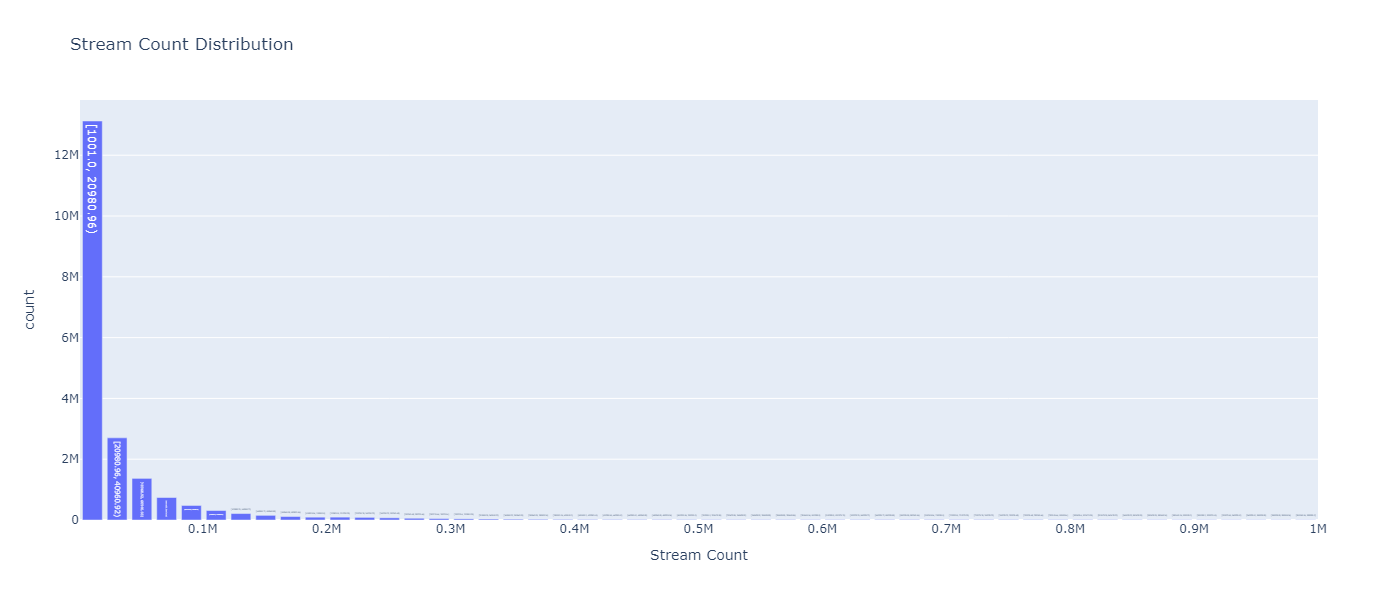

In [42]:
#histogram of stream count distribution
#filter outliers for stream counts - for use in stream histogram only
df2_viz_stm = ps.DataFrame(df2.filter(df2.streams < 1000000))

fig = df2_viz_stm["streams"].plot.hist(bins = 50, alpha = 0.5)

fig.update_layout(width = 1000, height = 600, title = "Stream Count Distribution", xaxis_title = "Stream Count")

fig.show()

The stream count distribution is skewed to the right, and is a unimodal distribution with one distinct peak

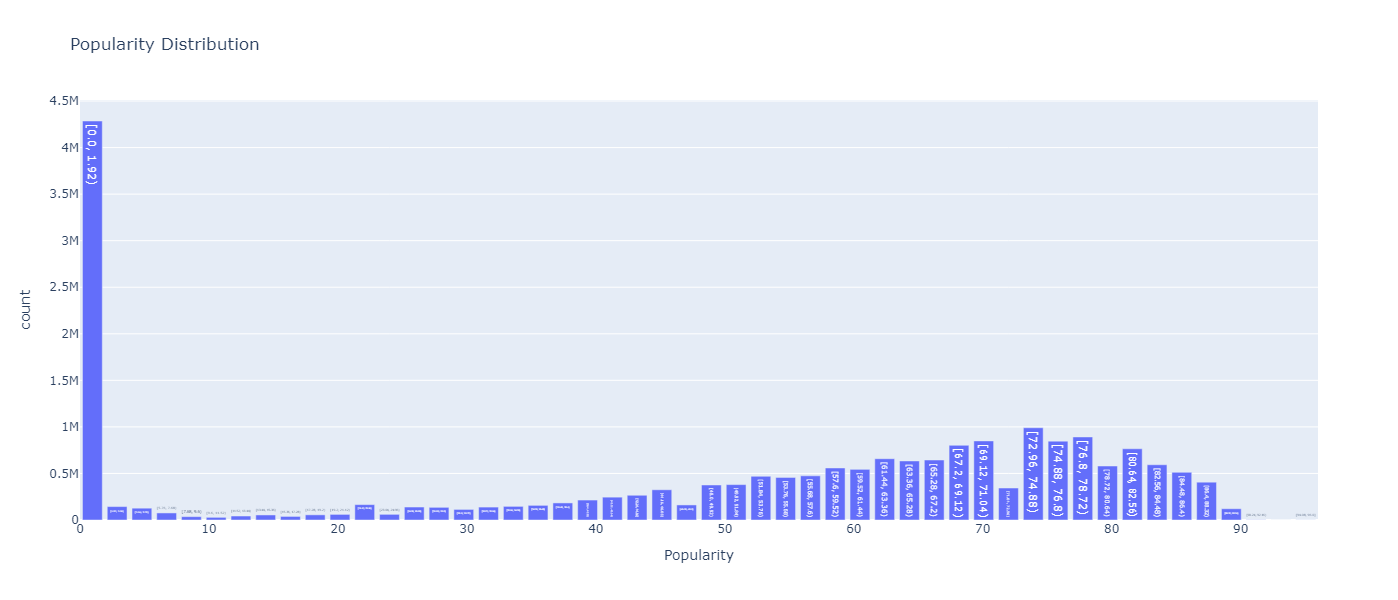

In [43]:
#histogram of popularity distribution
fig = df2_viz["popularity"].plot.hist(bins = 50, alpha = 0.5)

fig.update_layout(width = 1000, height = 600, title = "Popularity Distribution", xaxis_title = "Popularity")

fig.show()

The distribution of popularity is skewed to the right, and is a unimodal distribution with one distinct peak

In [44]:
#histogram of duration distribution
#filter outliers for duration - for use in duration histogram only
df2_viz_dur = ps.DataFrame(df2.filter(df2.duration_ms < 1000000))
fig = df2_viz_dur["duration_ms"].plot.hist(bins = 50, alpha = 0.5)

fig.update_layout(width = 1000, height = 600, title = "Duration Distribution", xaxis_title = "Duration (in ms)")

fig.show()

The distibution of duration follows a normal distribution, not skewed to the left or right

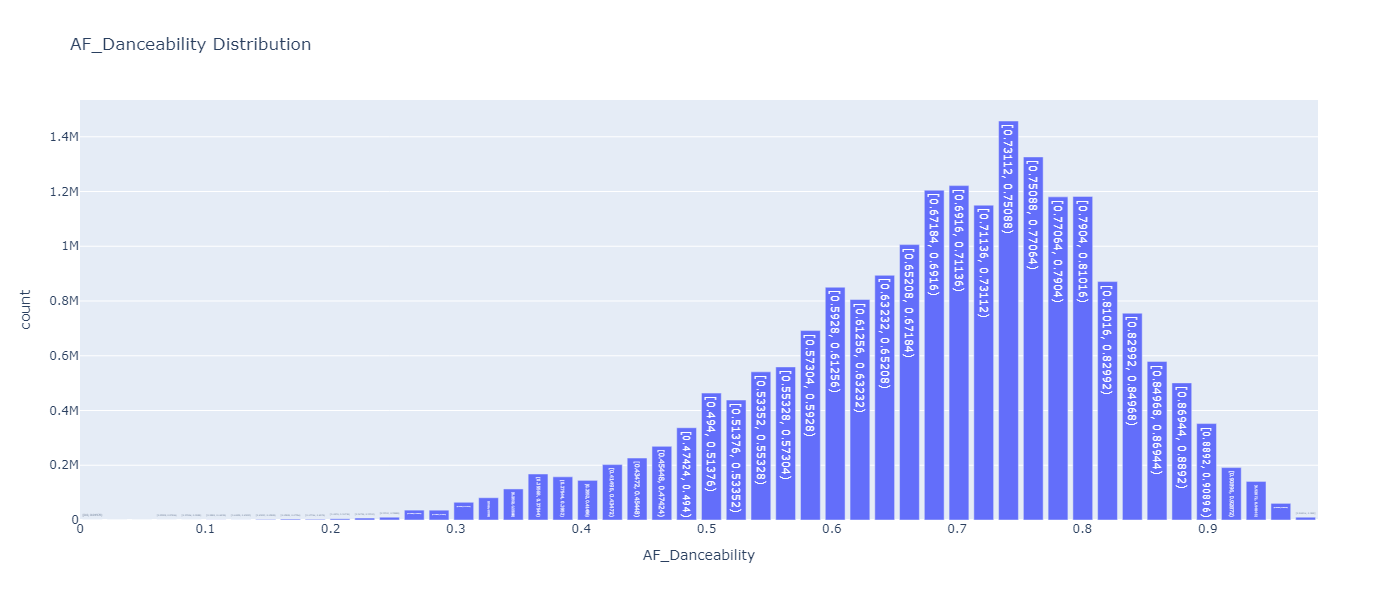

In [34]:
#histogram of af_danceability distribution
fig = df2_viz["af_danceability"].plot.hist(bins = 50, alpha = 0.5)

fig.update_layout(width = 1000, height = 600, title = "AF_Danceability Distribution", xaxis_title = "AF_Danceability")

fig.show()

The distribution for the af danceability column is skewed to the left, and is a slight multimodal distribution as there are more than two distinct peaks in the distribution 

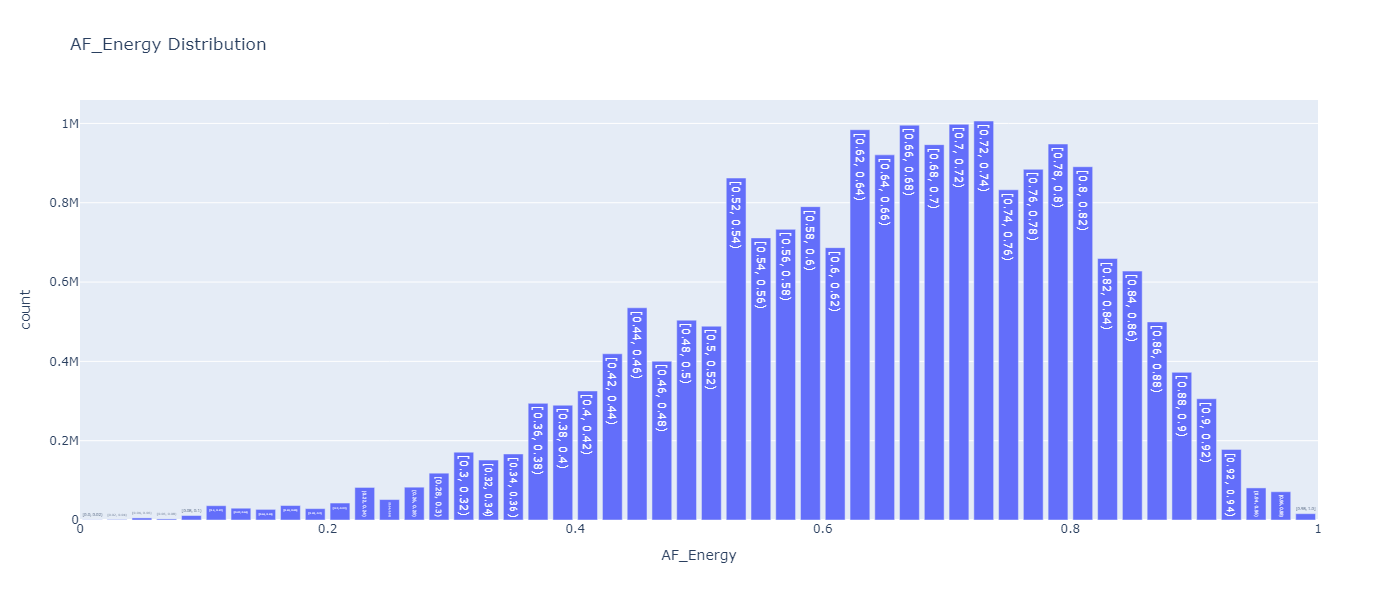

In [35]:
#histogram of af_energy distribution
fig = df2_viz["af_energy"].plot.hist(bins = 50, alpha = 0.5)

fig.update_layout(width = 1000, height = 600, title = "AF_Energy Distribution", xaxis_title = "AF_Energy")

fig.show()

The histogram for energy is skewed to the left and is a multi modal distribution, as there are more than two distinct peaks in this distribution 

In [36]:
#histogram of af_loudness distribution
fig = df2_viz["af_loudness"].plot.hist(bins = 50, alpha = 0.5)

fig.update_layout(width = 1000, height = 600, title = "AF_Loudness Distribution", xaxis_title = "AF_Loudness")

fig.show()

The distribution is skewed to the left and is a unimodal distribution, as there is one distinct peak in the distribution 

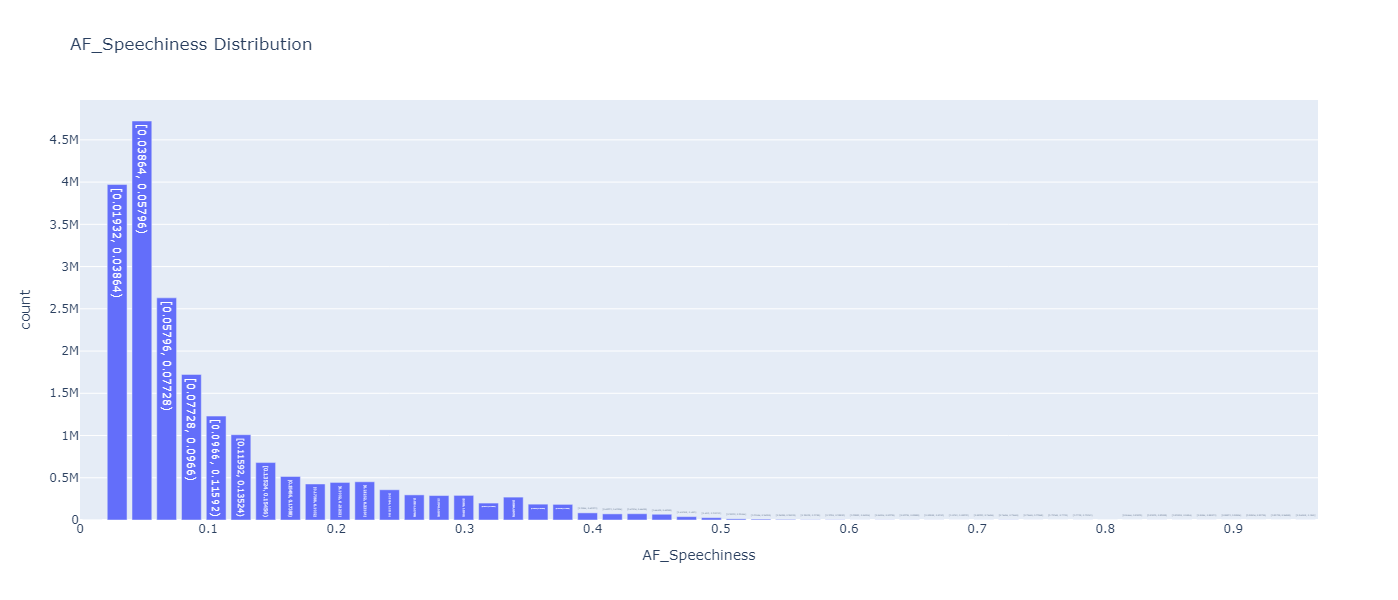

In [37]:
#histogram of af_speechiness distribution
fig = df2_viz["af_speechiness"].plot.hist(bins = 50, alpha = 0.5)

fig.update_layout(width = 1000, height = 600, title = "AF_Speechiness Distribution", xaxis_title = "AF_Speechiness")

fig.show()

The distribution for af speechiness is skewed to the right and this is a unimodal distribution, as there is one distinct peak 

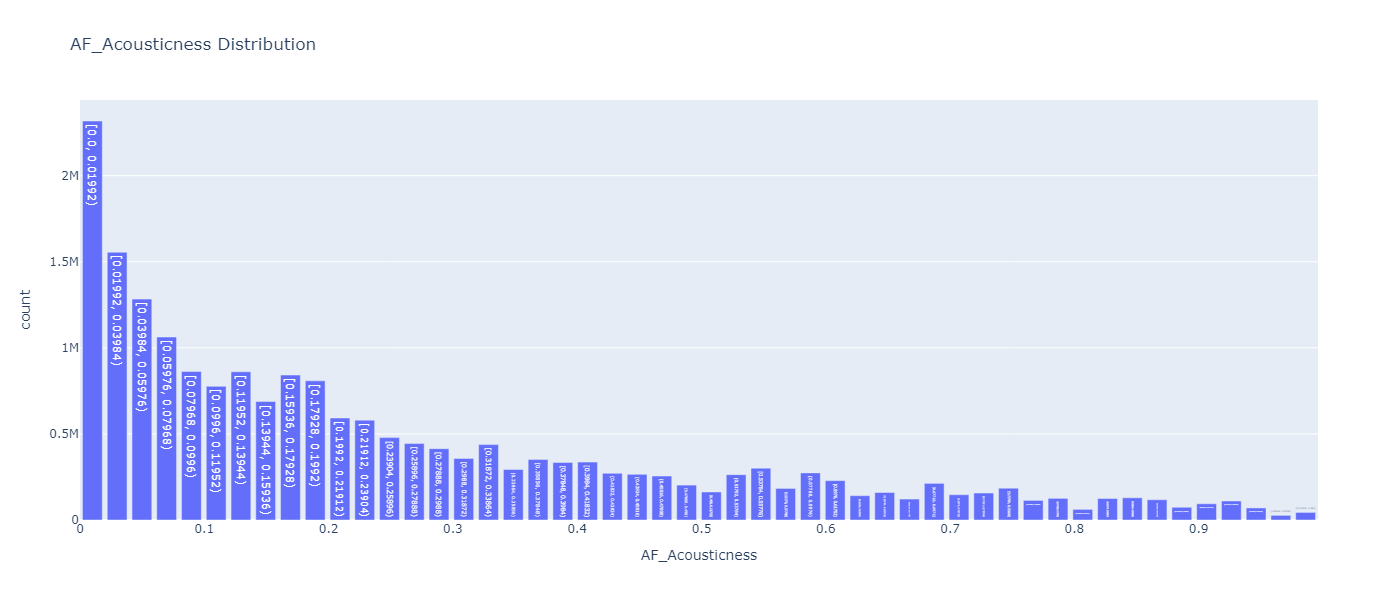

In [38]:
#histogram of af_acousticness distribution
fig = df2_viz["af_acousticness"].plot.hist(bins = 50, alpha = 0.5)

fig.update_layout(width = 1000, height = 600, title = "AF_Acousticness Distribution", xaxis_title = "AF_Acousticness")

fig.show()

The disitrbution for af acuosticness is skewed to the right and this is a multimodal distribution, as there are several distinct peaks

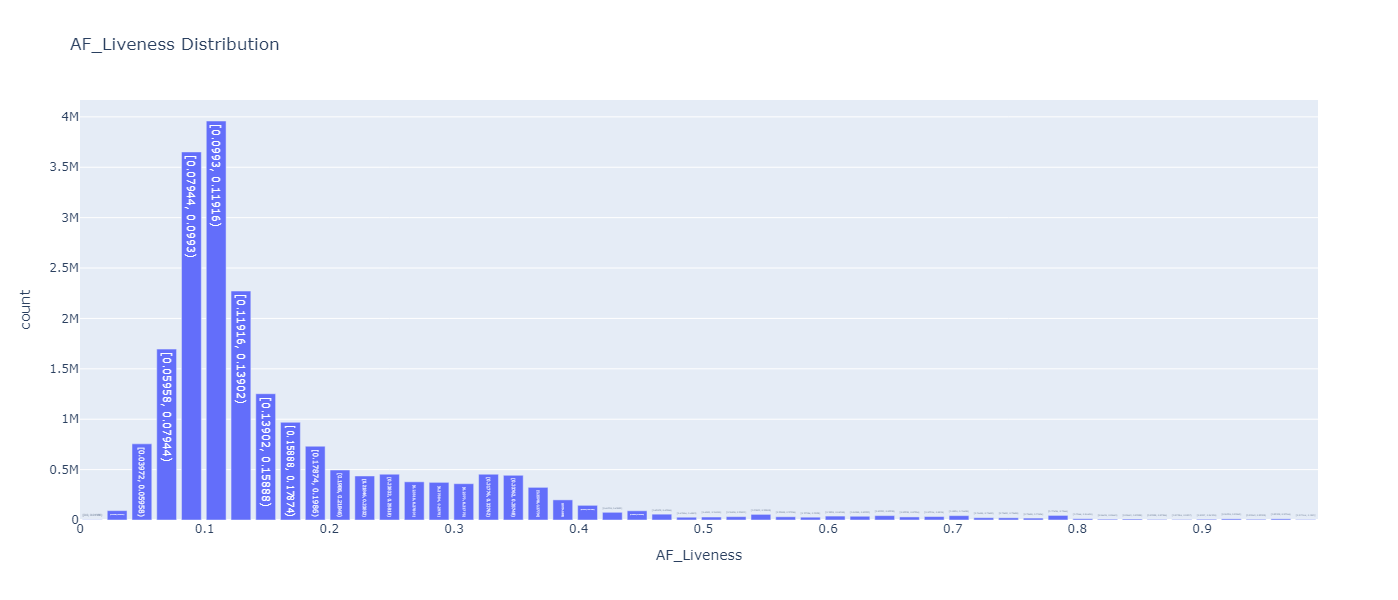

In [39]:
#histogram of af_liveness distribution
fig = df2_viz["af_liveness"].plot.hist(bins = 50, alpha = 0.5)

fig.update_layout(width = 1000, height = 600, title = "AF_Liveness Distribution", xaxis_title = "AF_Liveness")

fig.show()

The distrubtion for af liveness is skewed to the right and this is a unimodal distribution, as there is one distinct peak in this distribution 

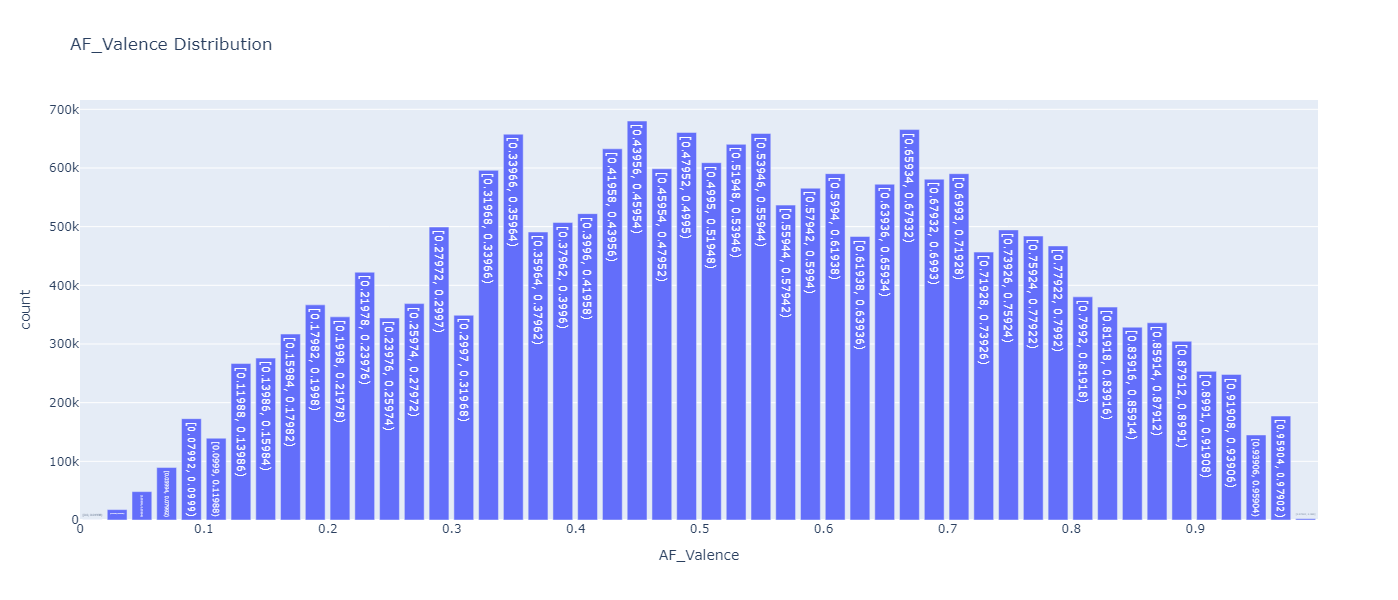

In [40]:
#histogram of af_valence distribution
fig = df2_viz["af_valence"].plot.hist(bins = 50, alpha = 0.5)

fig.update_layout(width = 1000, height = 600, title = "AF_Valence Distribution", xaxis_title = "AF_Valence")

fig.show()

The distrubtion isn't skewed in either direction and is a multimodal distribution, as there are more than two distinct peaks in this distribution 

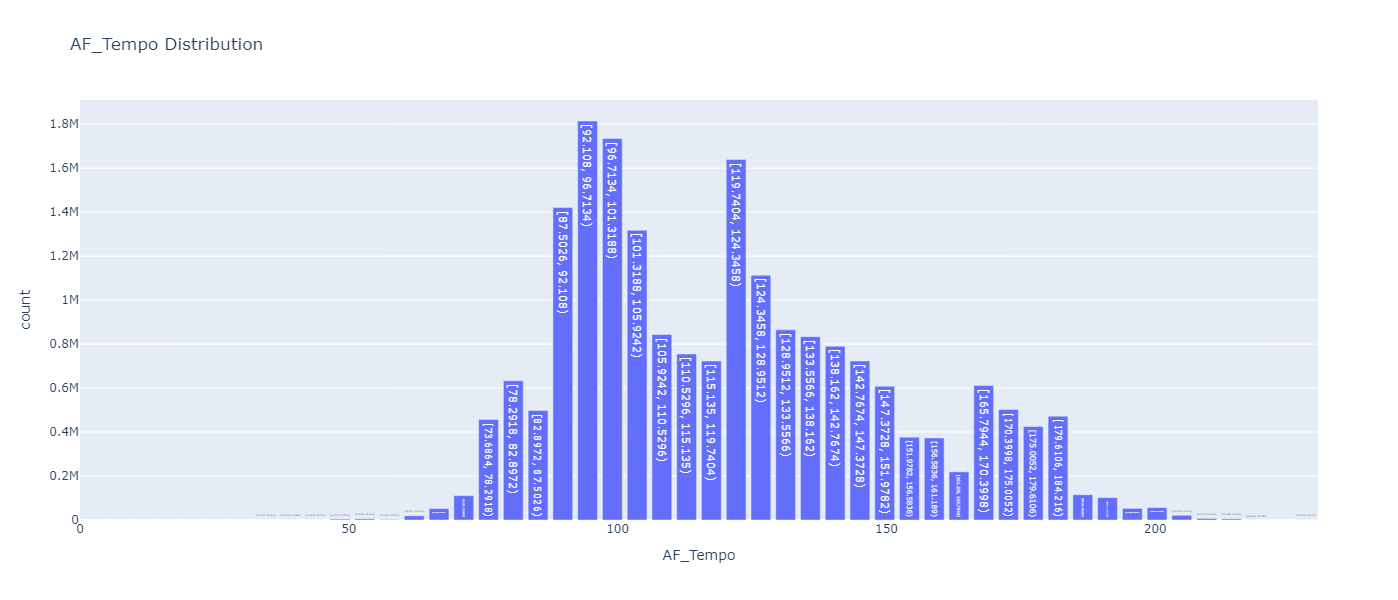

In [41]:
#histogram of af_tempo distribution
fig = df2_viz["af_tempo"].plot.hist(bins = 50, alpha = 0.5)

fig.update_layout(width = 1000, height = 600, title = "AF_Tempo Distribution", xaxis_title = "AF_Tempo")

fig.show()

The distribution is not skewed in either direction, and is a multi modal distribution, as there are more than two distinct peaks